In [1]:
import pandas as pd

In [2]:
filepath = r"C:\Users\janai\Downloads\DADOS.xlsx"
df_dados = pd.read_excel(filepath)

# Verificar as primeiras linhas e os tipos de dados
df_dados.head()

,ANO,MES,TOTAL_PASSAGEIROS,Valor_Cesta_Basica_BH,SELIC_aomes,TX_Desemprego,Nivel_Ocupacao,Rendimento_medio_real,IPC_Media_Mes,Incerteza,Antecedente_Emprego,CDI_%,IGP_M,ENVIDAMENTO,INPC_BH,SELIC,IPCA,Etanol_Preco,Gasolina_Preco,Salario_Minimo
0,2009,3,39682228,206.59,0.97,0.0,0.0,0,0.45,125.6,65.0,12.61,-0.74,23.27,-0.07,0.97,5.61,1.402,2.122,465
1,2009,4,36342697,214.55,0.84,0.0,0.0,0,0.62,117.1,67.3,11.13,-0.15,23.38,0.47,0.84,5.53,1.320,2.105,465
2,2009,5,37954533,216.09,0.77,0.0,0.0,0,0.48,111.8,73.0,10.13,-0.07,23.65,0.51,0.77,5.20,1.299,2.101,465
3,2009,6,37323493,218.18,0.76,0.0,0.0,0,0.26,109.1,76.2,10.00,-0.10,23.71,0.19,0.76,4.80,1.254,2.082,465
4,2009,8,37765061,213.51,0.69,0.0,0.0,0,0.26,106.8,83.9,8.63,-0.36,23.87,0.10,0.69,4.36,1.340,2.103,465


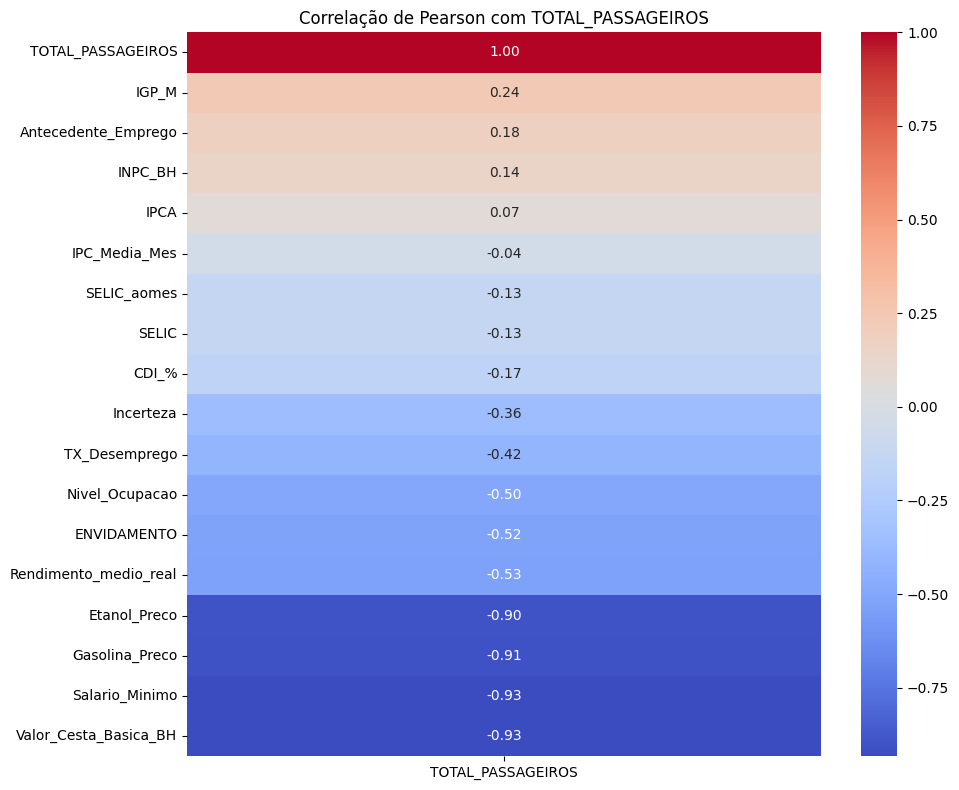

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Remover colunas não numéricas e colunas com muitos zeros (como 'Nivel_Ocupacao' e 'Rendimento_medio_real' no início)
colunas_validas = df_dados.select_dtypes(include=['number']).drop(columns=['ANO', 'MES']).copy()
colunas_validas = colunas_validas.loc[:, (colunas_validas != 0).any(axis=0)]

# Calcular correlação de Pearson
correlacoes = colunas_validas.corr()

# Visualizar as correlações com TOTAL_PASSAGEIROS
correlacao_total_passageiros = correlacoes[['TOTAL_PASSAGEIROS']].sort_values(by='TOTAL_PASSAGEIROS', ascending=False)

# Plotar o heatmap das principais correlações com TOTAL_PASSAGEIROS
plt.figure(figsize=(10, 8))
sns.heatmap(correlacoes[['TOTAL_PASSAGEIROS']].sort_values(by='TOTAL_PASSAGEIROS', ascending=False),
            annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlação de Pearson com TOTAL_PASSAGEIROS')
plt.tight_layout()
plt.show()



modelo autoregressivo       

In [4]:
df = df_dados.copy()

In [6]:
import sys
print(sys.executable)

c:\Users\janai\AppData\Local\Programs\Python\Python313\python.exe


In [8]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Garantir que as colunas corretas existam e tenham nomes padronizados
df = df.copy()
df['DIA'] = 1
df['DATA'] = pd.to_datetime(df[['ANO', 'MES', 'DIA']].rename(columns={'ANO': 'year', 'MES': 'month', 'DIA': 'day'}))
df = df.set_index('DATA').sort_index()

# Selecionar variáveis
dados_modelo = df[['TOTAL_PASSAGEIROS', 'Salario_Minimo', 'Valor_Cesta_Basica_BH']].dropna()

# Normalizar
scaler = StandardScaler()
dados_norm = pd.DataFrame(scaler.fit_transform(dados_modelo),
                          columns=dados_modelo.columns,
                          index=dados_modelo.index)

# Definir y e X
y = dados_norm['TOTAL_PASSAGEIROS']
X_exog = dados_norm[['Salario_Minimo', 'Valor_Cesta_Basica_BH']]

# Treinar modelo
modelo_ar = AutoReg(endog=y, lags=1, exog=X_exog).fit()

# Mostrar resultados
print(modelo_ar.summary())



                            AutoReg Model Results                             
Dep. Variable:      TOTAL_PASSAGEIROS   No. Observations:                  104
Model:                   AutoReg-X(1)   Log Likelihood                 -32.045
Method:               Conditional MLE   S.D. of innovations              0.330
Date:                seg, 09 jun 2025   AIC                             74.091
Time:                        16:32:04   BIC                             87.265
Sample:                             1   HQIC                            79.427
                                  104                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0068      0.033     -0.210      0.834      -0.071       0.057
TOTAL_PASSAGEIROS.L1      0.2693      0.091      2.950      0.003       0.090       0.448
Salario_

c:\Users\janai\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


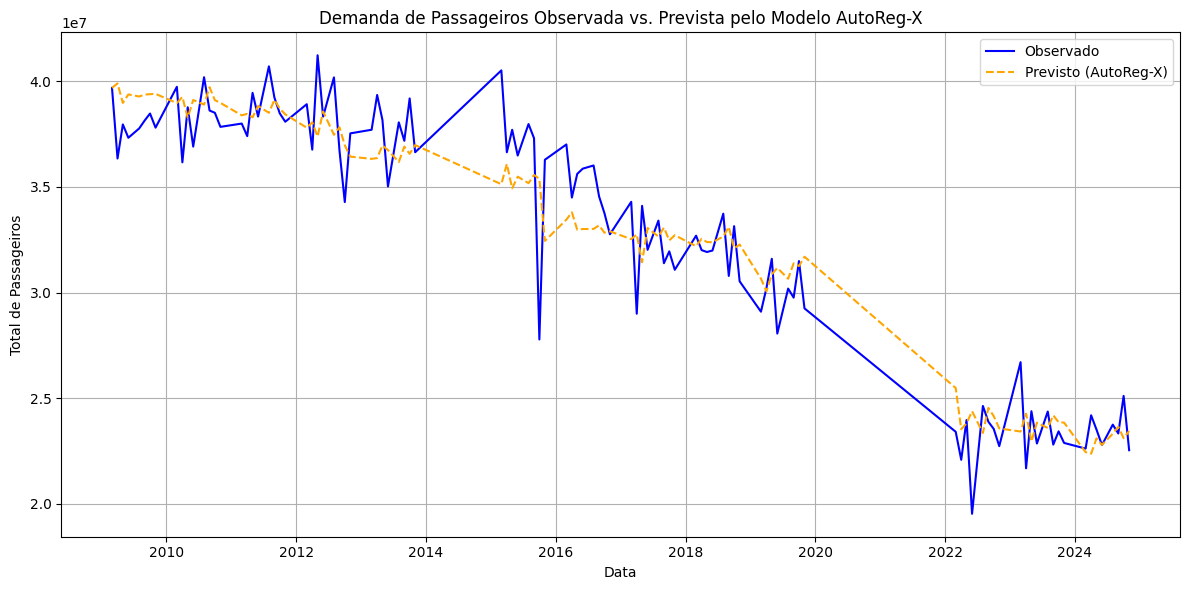

In [9]:
import matplotlib.pyplot as plt

# Obter os valores previstos do modelo (ajustados ao histórico)
y_fitted = modelo_ar.fittedvalues

# Inverter a normalização para trazer de volta os passageiros reais
# Precisamos reconstruir um DataFrame com as colunas normalizadas, incluindo os valores previstos
dados_reconstruidos = dados_norm.copy()
dados_reconstruidos.loc[y_fitted.index, 'TOTAL_PASSAGEIROS'] = y_fitted

# Inverter a normalização
dados_desnormalizados = pd.DataFrame(
    scaler.inverse_transform(dados_reconstruidos),
    columns=dados_modelo.columns,
    index=dados_reconstruidos.index
)

# Extraímos os valores observados e previstos
observado = dados_modelo['TOTAL_PASSAGEIROS']
previsto = dados_desnormalizados['TOTAL_PASSAGEIROS']

# Plotando o gráfico
plt.figure(figsize=(12, 6))
plt.plot(observado, label='Observado', color='blue')
plt.plot(previsto, label='Previsto (AutoReg-X)', color='orange', linestyle='--')
plt.title('Demanda de Passageiros Observada vs. Prevista pelo Modelo AutoReg-X')
plt.xlabel('Data')
plt.ylabel('Total de Passageiros')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
# Reimportar bibliotecas e recarregar os dados após o reset
import pandas as pd


# Preparar a coluna de data
df = df.rename(columns={'ANO': 'year', 'MES': 'month'})
df['day'] = 1
df['DATA'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.set_index('DATA').sort_index()

# Selecionar colunas usadas no modelo
dados_modelo = df[['TOTAL_PASSAGEIROS', 'Salario_Minimo', 'Valor_Cesta_Basica_BH']].dropna()

# Preparar dados para XGBoost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


# Criar defasagem
dados_xgb = dados_modelo.copy()
dados_xgb['lag1_passageiros'] = dados_xgb['TOTAL_PASSAGEIROS'].shift(1)
dados_xgb = dados_xgb.dropna()

# Variáveis independentes e alvo
X = dados_xgb[['Salario_Minimo', 'Valor_Cesta_Basica_BH', 'lag1_passageiros']]
y = dados_xgb['TOTAL_PASSAGEIROS']

# Separar treino e teste (últimos 6 meses para teste)
X_train, X_test = X.iloc[:-6], X.iloc[-6:]
y_train, y_test = y.iloc[:-6], y.iloc[-6:]

# Treinar modelo
modelo_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
modelo_xgb.fit(X_train, y_train)

# Previsões
y_pred_xgb = modelo_xgb.predict(X_test)

# Construir DataFrame de resultados
df_forecast_xgb = pd.DataFrame({
    'DATA': y_test.index,
    'OBSERVADO': y_test.values,
    'PREV_XGBOOST': y_pred_xgb
}).set_index('DATA')

In [32]:
df_forecast_xgb

,OBSERVADO,PREV_XGBOOST
DATA,,
2024-05-01,23523864,21613020.0
2024-06-01,22786472,22577320.0
2024-08-01,23751798,26646202.0
2024-09-01,23334742,23679836.0
2024-10-01,25110681,22820152.0
2024-11-01,22542937,22409636.0


In [33]:
df_forecast_xgb['DIF_PERCENTUAL'] = (1 - ((df_forecast_xgb['PREV_XGBOOST'] / df_forecast_xgb['OBSERVADO']))).round(2)*100


In [34]:
df_forecast_xgb

,OBSERVADO,PREV_XGBOOST,DIF_PERCENTUAL
DATA,,,
2024-05-01,23523864,21613020.0,8.0
2024-06-01,22786472,22577320.0,1.0
2024-08-01,23751798,26646202.0,-12.0
2024-09-01,23334742,23679836.0,-1.0
2024-10-01,25110681,22820152.0,9.0
2024-11-01,22542937,22409636.0,1.0


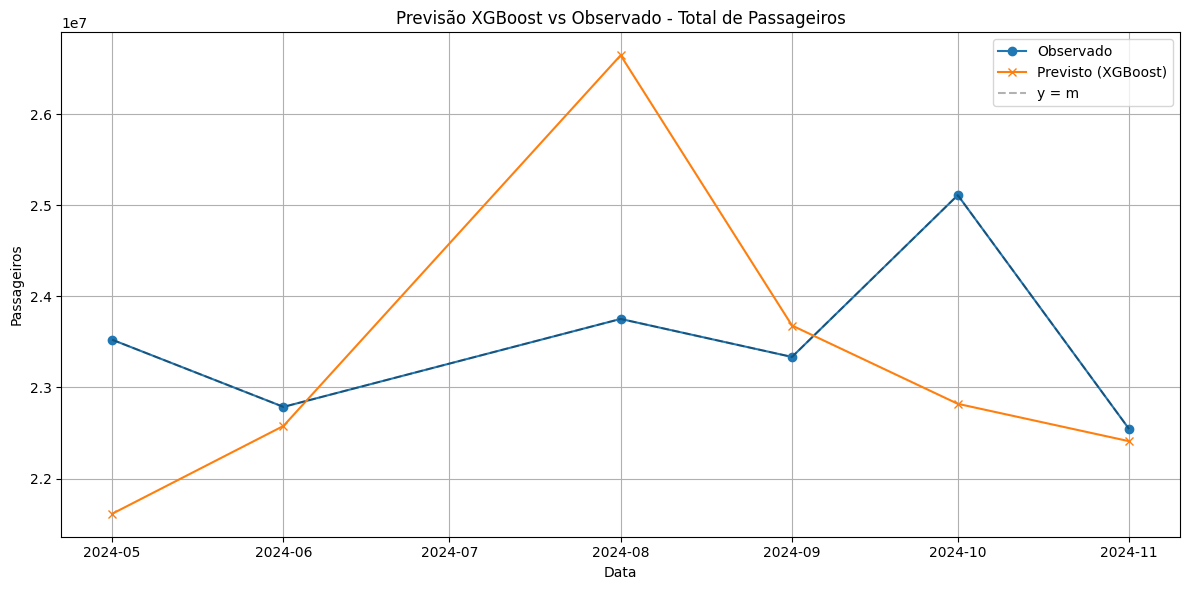

In [11]:
# Reimportar bibliotecas e recarregar os dados após o reset
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error



# Preparar a coluna de data
df = df.rename(columns={'ANO': 'year', 'MES': 'month'})
df['day'] = 1
df['DATA'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.set_index('DATA').sort_index()

# Selecionar colunas usadas no modelo
dados_modelo = df[['TOTAL_PASSAGEIROS', 'Salario_Minimo', 'Valor_Cesta_Basica_BH']].dropna()

# Criar defasagem
dados_xgb = dados_modelo.copy()
dados_xgb['lag1_passageiros'] = dados_xgb['TOTAL_PASSAGEIROS'].shift(1)
dados_xgb = dados_xgb.dropna()

# Variáveis independentes e alvo
X = dados_xgb[['Salario_Minimo', 'Valor_Cesta_Basica_BH', 'lag1_passageiros']]
y = dados_xgb['TOTAL_PASSAGEIROS']

# Separar treino e teste (últimos 6 meses para teste)
X_train, X_test = X.iloc[:-6], X.iloc[-6:]
y_train, y_test = y.iloc[:-6], y.iloc[-6:]

# Treinar modelo
modelo_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
modelo_xgb.fit(X_train, y_train)

# Previsões
y_pred_xgb = modelo_xgb.predict(X_test)

# Construir DataFrame de resultados
df_forecast_xgb = pd.DataFrame({
    'DATA': y_test.index,
    'OBSERVADO': y_test.values,
    'PREV_XGBOOST': y_pred_xgb
}).set_index('DATA')

# Calcular diferença percentual
df_forecast_xgb['DIF_PERC'] = ((df_forecast_xgb['PREV_XGBOOST'] - df_forecast_xgb['OBSERVADO']) / df_forecast_xgb['OBSERVADO']) * 100

# Plotar gráfico de previsão vs observado
plt.figure(figsize=(12, 6))
plt.plot(df_forecast_xgb.index, df_forecast_xgb['OBSERVADO'], label='Observado', marker='o')
plt.plot(df_forecast_xgb.index, df_forecast_xgb['PREV_XGBOOST'], label='Previsto (XGBoost)', marker='x')
plt.plot(df_forecast_xgb.index, df_forecast_xgb['OBSERVADO'], 'k--', label='y = m', alpha=0.3)
plt.title('Previsão XGBoost vs Observado - Total de Passageiros')
plt.xlabel('Data')
plt.ylabel('Passageiros')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

